In [24]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
np.random.seed(42)

species_of_interest = ["@H2SIO", "H", "H2", "O", "C", "N", "CL", "E-", "CO", "MG", "#C", "H2O", "SI", 'SURFACE', 'BULK', 'C+']
physical_params = ['density', 'gasTemp', 'av', 'radField']

In [25]:
x = os.listdir('data/chemistry_tracers_csv/')
y = []
for file in x:
    if file == "M600_1_1_Tracer_10_.csv":
        continue
    y.append(int(file.replace('M600_1_1_Tracer_', '').replace('.csv', '')))

indices = list(sorted(set(y)))
print(indices)

[216, 2585, 2761, 2767, 4548, 8814, 9712, 10063, 19592]


In [3]:
indices = [10]

In [26]:
results = {}
file_scores = []
files_summary = []

for ind in indices:
    try:
        df = pd.read_csv(f"data/chemistry_tracers_csv/M600_1_1_Tracer_{ind}.csv")

        stiffness = {
            col: np.log10(df[col][df[col] > 0]).clip(lower=-20).diff().abs().mean()
            for col in df.select_dtypes(include=[np.number]).columns
        }
        results[ind] = stiffness

        file_score = np.mean([val for val in stiffness.values() if val is not None])
        file_scores.append((ind, file_score))

        top5_species = sorted(
            stiffness.items(),
            key=lambda x: x[1] if x[1] is not None else -np.inf,
            reverse=True
        )[:5]

        files_summary.append({
            "ind": ind,
            "species": [col for col, _ in top5_species],
            "values": [val for _, val in top5_species],
            "score": file_score
        })

    except Exception as e:
        print(f"Error reading file {ind}: {e}")

files_summary = sorted(files_summary, key=lambda x: x["score"], reverse=True)

print("\nFiles ranked by overall stiffness:")
for file in files_summary:
    print(f"\nFile {file['ind']}: Overall stiffness {file['score']:.4f}")
    for col, val in zip(file["species"], file["values"]):
        print(f"  {col}: {val:.4f}")



Files ranked by overall stiffness:

File 9712: Overall stiffness 0.0364
  #H2CO: 0.1665
  #CH4: 0.1553
  #HCO: 0.1497
  #CH2: 0.1479
  #H2: 0.1478

File 19592: Overall stiffness 0.0319
  #H2: 0.1682
  #H2COH: 0.1545
  #H: 0.1452
  #CH3OH: 0.1413
  #H2CO: 0.1283

File 2761: Overall stiffness 0.0299
  #CH3OH: 0.1595
  #H: 0.1475
  #H2: 0.1465
  #NH2: 0.1420
  #N: 0.1411

File 10063: Overall stiffness 0.0269
  #H2CO: 0.1329
  #H2: 0.1277
  #H: 0.1200
  #HCO: 0.1169
  #N: 0.1091

File 2585: Overall stiffness 0.0263
  #H2: 0.1292
  #H: 0.1269
  NH3: 0.1037
  NH2: 0.1012
  #CH3: 0.1011

File 216: Overall stiffness 0.0258
  #H2: 0.1379
  #H: 0.1028
  #H2CO: 0.1006
  #H2COH: 0.0989
  #HCO: 0.0965

File 8814: Overall stiffness 0.0256
  #H2: 0.1206
  #H: 0.1144
  #CH3OH: 0.1033
  #NH2: 0.0953
  #H2COH: 0.0951

File 4548: Overall stiffness 0.0238
  #H2: 0.1049
  #H: 0.0971
  #H2COH: 0.0833
  #C: 0.0786
  #CH3: 0.0777

File 2767: Overall stiffness 0.0227
  #H2: 0.1087
  #H: 0.0889
  #C: 0.0737
  

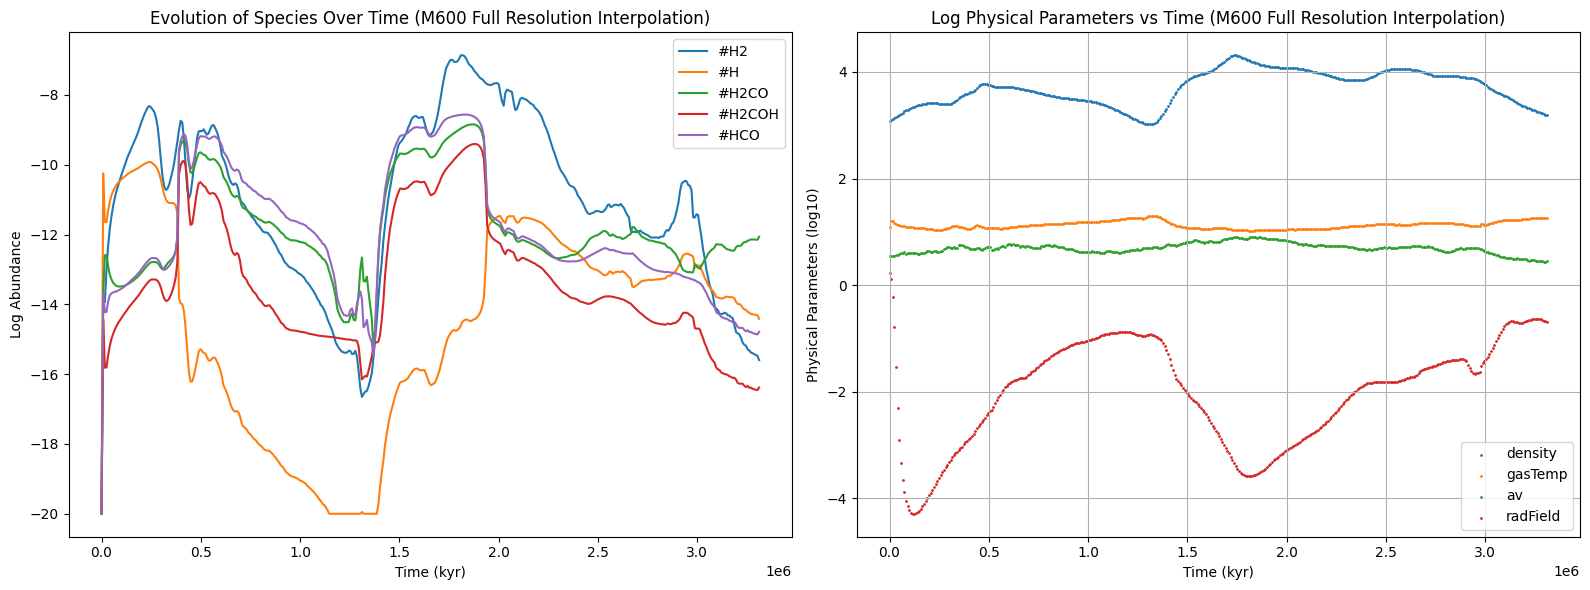

In [34]:
file_idx = 5
species_of_interest = files_summary[file_idx]["species"]
df = pd.read_csv(f'data/chemistry_tracers_csv/M600_1_1_Tracer_{files_summary[file_idx]["ind"]}.csv')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

#species_of_interest = ["C2H34"]
for species in species_of_interest:
    if species in df.columns:
        log_abundance = np.log10(df[species].replace(0, np.nan))
        log_abundance = np.maximum(log_abundance, -20)
        ax1.plot(df['time'], log_abundance, label=species)

ax1.set_xlabel('Time (kyr)')
ax1.set_ylabel('Log Abundance')
ax1.set_title('Evolution of Species Over Time (M600 Full Resolution Interpolation)')
ax1.legend()

for param in physical_params:
    if param in df.columns:
        y = pd.to_numeric(np.log10(df[param]), errors='coerce')
        ax2.scatter(df['time'], y, label=param, s=1)

ax2.set_xlabel('Time (kyr)')
ax2.set_ylabel('Physical Parameters (log10)')
ax2.set_title('Log Physical Parameters vs Time (M600 Full Resolution Interpolation)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

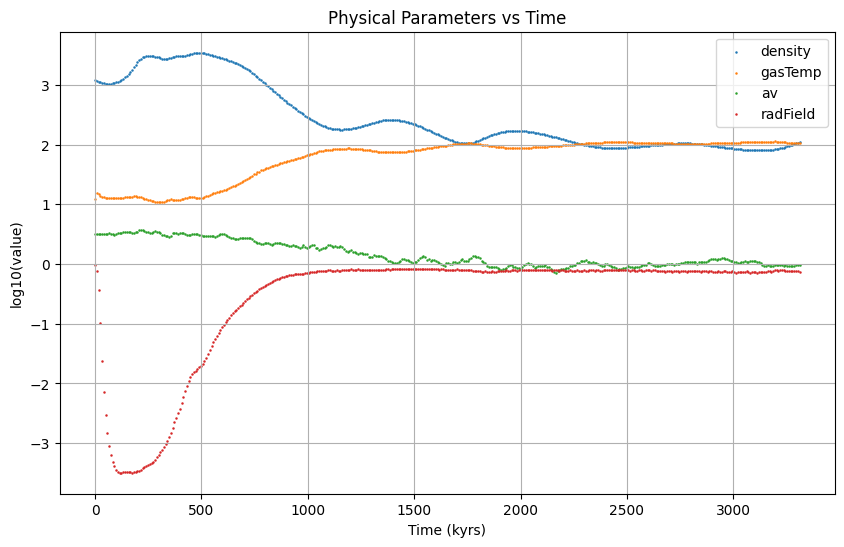

In [22]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
np.random.seed(42)

df1 = pd.read_csv("data/turbulence_tracers_csv/M600_1_1_Tracer_5170.csv")
physical_params = ['density', 'gasTemp', 'av', 'radField']

plt.figure(figsize=(10, 6))
for param in physical_params:
    plt.scatter(df1['time'], np.log10(df1[param].clip(lower=1e-30)), label=param, s=0.6)
plt.xlabel("Time (kyrs)")
plt.ylabel("log10(value)")
plt.title("Physical Parameters vs Time")
plt.legend()
plt.grid(True)
plt.show()

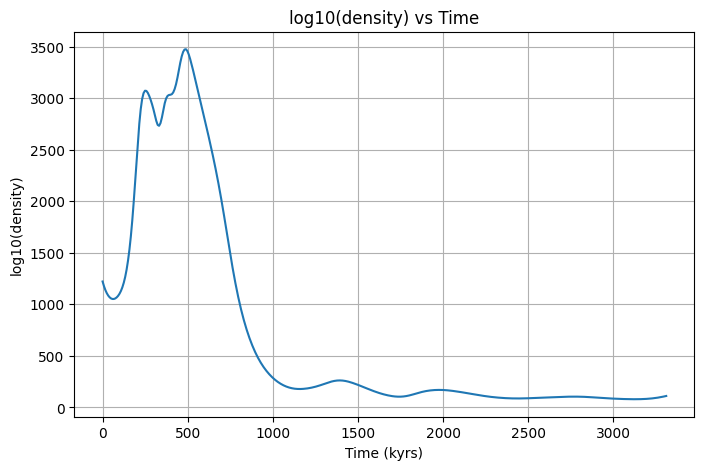

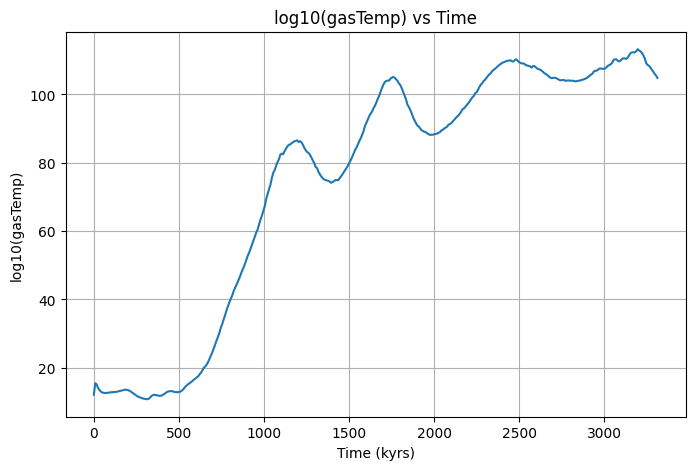

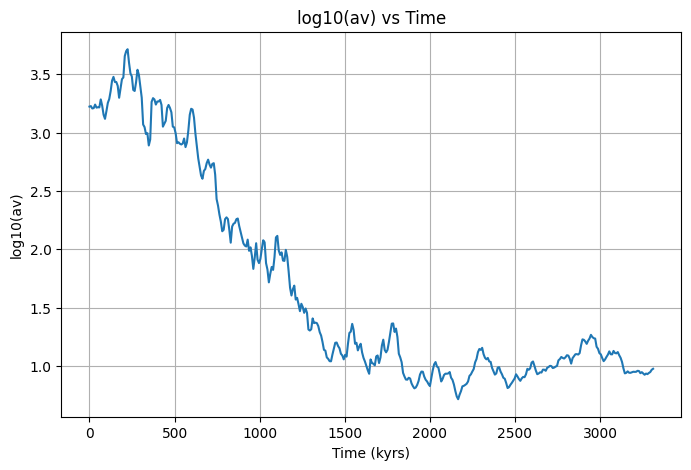

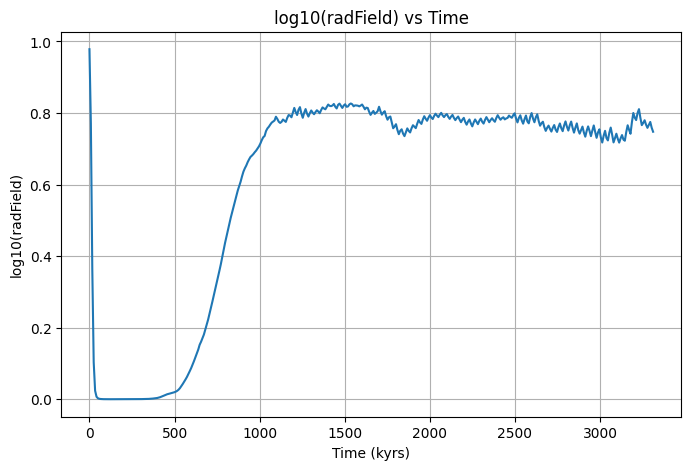

In [23]:
for param in physical_params:
    plt.figure(figsize=(8, 5))
    plt.plot(df1['time'], (df1[param].clip(lower=1e-30)))
    plt.xlabel("Time (kyrs)")
    plt.ylabel(f"log10({param})")
    plt.title(f"log10({param}) vs Time")
    plt.grid(True)
    plt.show()
